# Structured light

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

path = "data/casper/"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 3D Scanning

In [2]:
c = np.load(path + "calib.npy", allow_pickle=True).item()

K0 = c["K0"]
d0 = c["d0"]
K1 = c["K1"]
d1 = c["d1"]
R1 = c["R"]
t1 = c["t"]

K = {0: K0, 1: K1}
d = {0: d0, 1: d1}

## 1. Calibration
Find extrinsics and intrinsics: use a checkerboard and Zhang's method.
# TODO
review that.

## 2 Rectify images

In [3]:
def grayscale(im):
    return np.sum(im, axis=2) / 3

In [4]:
ims0, ims1 = [], []
n_patterns = 26
for pattern in range(n_patterns):
    im0 = grayscale(cv2.imread(path + f"sequence/frames{0}_{pattern}.png"))
    im1 = grayscale(cv2.imread(path + f"sequence/frames{1}_{pattern}.png"))
    size = (im0.shape[1], im0.shape[0])
    stereo = cv2.stereoRectify(
        c['K0'],
        c['d0'],
        c['K1'],
        c['d1'],
        size,
        c['R'],
        c['t'],
        flags=0
    )
    R0, R1, P0, P1 = stereo[:4]
    maps0 = cv2.initUndistortRectifyMap(
        c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2
    )
    maps1 = cv2.initUndistortRectifyMap(
        c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2
    )
    ims0.append(cv2.remap(im0, *maps0, cv2.INTER_LINEAR))
    ims1.append(cv2.remap(im1, *maps1, cv2.INTER_LINEAR))

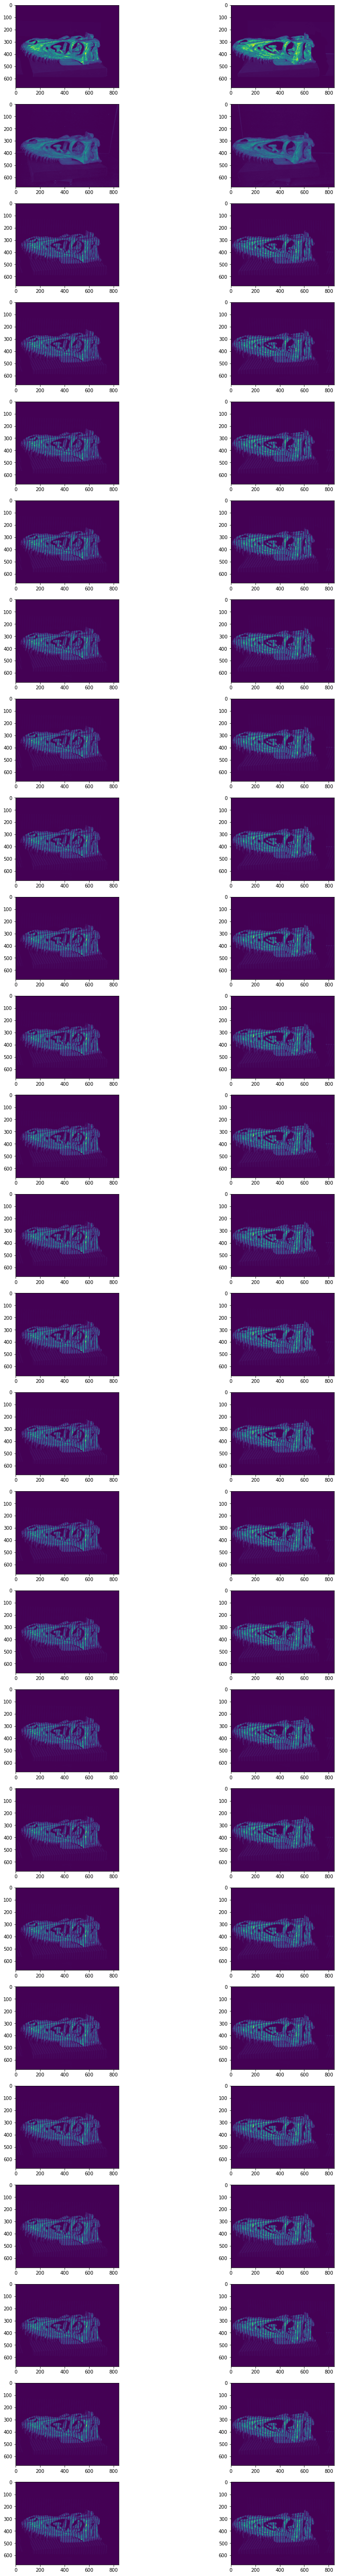

In [5]:
fig, ax = plt.subplots(n_patterns, 2, figsize=(15, 100))
for i in range(n_patterns):
    ax[i][0].imshow(ims0[i])
    ax[i][1].imshow(ims1[i])

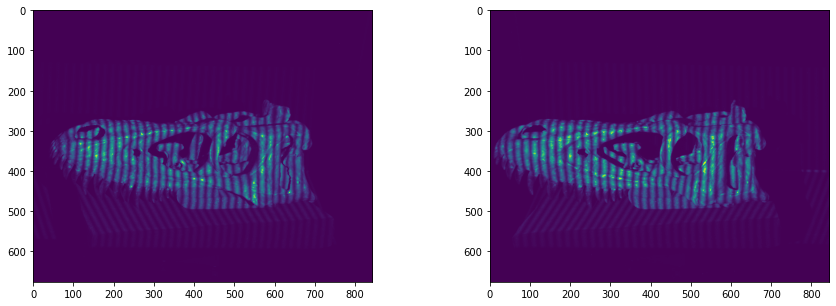

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2, 3):
    ax[0].imshow(ims0[i])
    ax[1].imshow(ims1[i])

In [11]:
def unwrap(ims, n1=40):
    """
    Compute the phases for each camera.

    Parameters
    ----------
    ims: primary images
    """
    fft_primary = np.fft.rfft(ims[2:18], axis=0)
    theta_primary = np.angle(fft_primary[1])
    fft_secondary = np.fft.rfft(ims[18:26], axis=0)
    theta_secondary = np.angle(fft_secondary[1])

    theta_c = (theta_primary - theta_secondary) % (2 * np.pi)
    o_primary = np.rint((n1 * theta_c - theta_primary) / 2 / np.pi)

    theta = ((2 * np.pi * o_primary + theta_primary) / n1) % (2 * np.pi)
    
    return theta

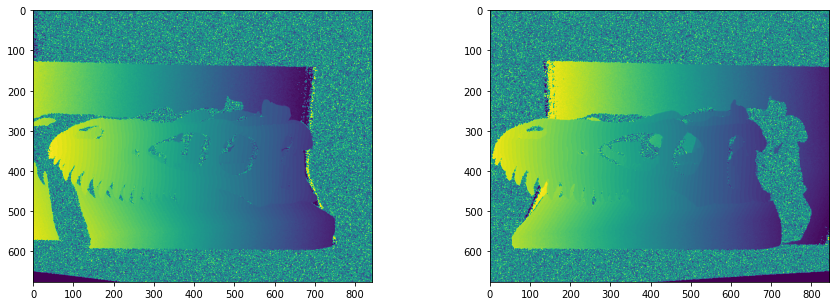

In [12]:
theta0 = unwrap(ims0)
theta1 = unwrap(ims1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(theta0);
ax[1].imshow(theta1);

## 4 Mask

In [13]:
mask0 = ims0[0] - ims0[1] > 15
mask1 = ims1[0] - ims1[1] > 15

theta0[~mask0] = 0
theta1[~mask1] = 0

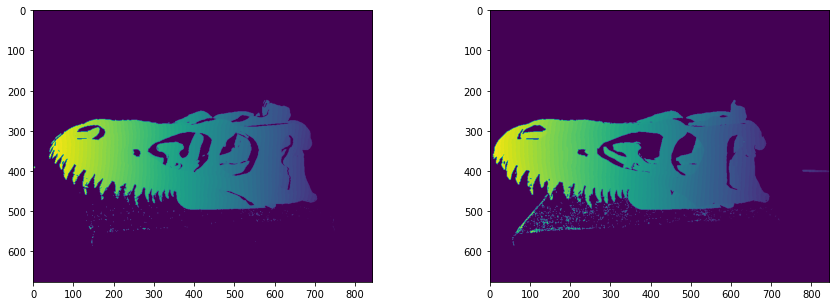

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(theta0);
ax[1].imshow(theta1);

## 5 Matches

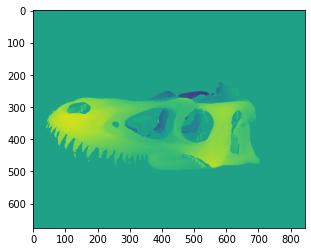

In [16]:
h, w = theta0.shape
disparity = np.zeros((h, w))
matches0 = []
matches1 = []
for i in range(h):
    for j0 in range(w):
        if mask0[i, j0]:
            min_disp = 300
            for j1 in range(w):
                disp = theta0[i, j0] - theta1[i, j1]
                if np.abs(disp) < min_disp:
                    disparity[i, j0] = j0 - j1
                    min_disp = np.abs(disp)
                    j_opt = j1
            if mask1[i, j_opt]:
                matches0.append([j0, i])
                matches1.append([j_opt, i])
plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5));

In [15]:
matches0 = np.array(matches0, dtype=np.float32).T
matches1 = np.array(matches1, dtype=np.float32).T

## 6 Triangulation

In [16]:
Q = cv2.triangulatePoints(P0, P1, matches0, matches1)
Q = Q[:-1] / Q[-1]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q.T)
o3d.visualization.draw_geometries([pcd])

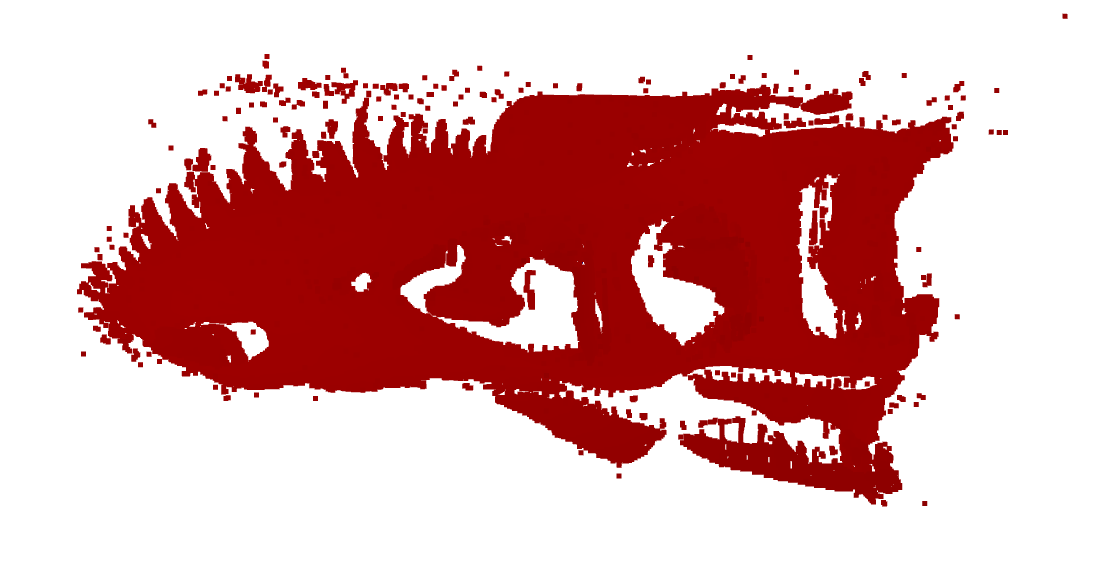